# Welcome to the TELL Quickstarter! 

### **`tell` is an open-source Python package for projecting future electricty load in the United States.**

## A little about `tell`

The Total ELectricity Load (TELL) model projects the short- and long-term evoluation of hourly electricity demand in response to future climate and population changes. The purpose of `tell` is to generate end-of-century hourly profiles of electricity demand across the entire United States (U.S.) at a spatial resolution adequate for input to a unit commitment/economic dispatch (UC/ED) model while also maintaining consistency with the long-term growth and evolution of annual state-level electricity demand projected by an economically driven human-Earth system model. `tell` takes as input future projections of the hourly time-series of meteorology and decadal populations and uses the temporal variations in weather to project hourly profiles of total electricity demand. The core predictions in `tell` are based on a series of multilayer perceptron (MLP) models for individual Balancing Authorities (BAs). Those MLP models are trained on historical observations of weather and electricity demand. Hourly projections from `tell` are scaled to match the annual state-level total electricity loads projected by the U.S. version of the Global Change Analysis Model (GCAM-USA). GCAM-USA captures the long-term co-evolution of the human-Earth system. Using this unique approach allows `tell` to reflect both changes in the shape of the load profile due to variations in weather and the long-term evolution of energy demand due to changes in population, technology, and economics. `tell` is unique from other probabilistic load forecasting models in that it features an explicit spatial component that allows us to relate projected loads to where they would occur spatially within a grid operations model. The output of `tell` is a series of hourly projections for future electricity demand at the county, state, and BA scale that are quantitatively and conceptually consistent with one another. More information about how the model works and how it can be fully applied are available on the [Read the Docs](https://immm-sfa.github.io/tell/index.html) site for `tell`.

## Lets get started! 

In this quickstarter we will walk through a series of steps for exploring `tell`, starting with importing the package and ending with visualizing the output. This quickstarter is based on a subset of example forcing data for `tell`. This allows the user to walk through the entire `tell` package in a matter of minutes. For the visualizations throughout this notebook, the user can choose whether or not to save these plots by setting the "save_images" and "image_resolution" flags in each function.

## 1. Install `tell`

`tell` is available via GitHub repository by using the pip install functionality below.

In [ ]:
pip install git+https://github.com/IMMM-SFA/tell.git

In [1]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell


## 2. Install the package of raw data underpinning `tell`

`tell` is based on open-source publicly accessible data. For convienence, we've packaged all of the core data underpinning `tell` into a [Zenodo data package](https://zenodo.org/record/5714756#.YhkTjxPMJTY). In order to run this notebook, first set the local directory where you would like to store the package data and the run the "install_package_data" function below. Note that the raw data package will require ~1.6 GB of storage and can take several minutes to download.

In [2]:
# Identify the current working directory, the "tell_data" directory where the data will be stored, and the image output directory:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
tell_data_dir = os.path.join(current_dir, r'tell_data')
tell_image_dir = os.path.join(tell_data_dir, r'outputs', r'visualizations')

# If the "tell_data" subdirectory doesn't exist then create it:
if not os.path.exists(tell_data_dir):
   os.makedirs(tell_data_dir)

# If the "tell_image_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_image_dir):
   os.makedirs(tell_image_dir)


In [ ]:
# Download the TELL raw data package from Zenodo:
tell.install_tell_raw_data(data_dir = tell_data_dir)


## 3. Pre-process the data needed for `tell`

In the next few code blocks we will load and process the necessary data for `tell`. The raw data (i.e., historical loads, population, meteorology, etc.) is in a variety of different formats determined by their originating organization (e.g., the Energy Information Agency). This series of processing steps cleans the raw data and converts it into a set of simplified .csv files which can be combined together and used as input to the MLP model training steps. Follow the sequence below to pre-process the `tell` input data. If you have already finished this step you can proceed to section 4.

### 3.1. Spatially mapping BAs to counties

The code block underpins the spatial component of `tell`. The function "map_ba_service_territory" uses information about Balancing Authorities (BAs) from the [EIA-861](https://www.eia.gov/electricity/data/eia861/) dataset to spatially map BAs to U.S. counties. This allows us to assign loads projected for individual BAs in `tell` to where they would occur with respect to each other spatially. More information about how BAs are mapped is available on the [Read the Docs](https://immm-sfa.github.io/tell/index.html) site for `tell`.

In [ ]:
# Execute the mapping function for all years from 2015 to 2020:
tell.map_ba_service_territory(start_year = 2015,
                              end_year = 2020,
                              data_input_dir = tell_data_dir)


In [ ]:
# See the output of the mapping step by plotting the service territory for a given BA (e.g., PJM, CISO, ERCO, etc.) in a given year (e.g., 2015-2020):
tell.plot_ba_service_territory(ba_to_plot = 'PJM',
                               year_to_plot = '2020',
                               data_input_dir = tell_data_dir, 
                               image_output_dir = tell_image_dir,
                               image_resolution = 150,
                               save_images = False)


### 3.2. Process the EIA-930 historical hourly demand dataset

Here we convert the raw EIA-930 hourly electricity demand data for BAs from Excel files to .csv files. The function "process_eia_930" also subsets the EIA-930 dataset to only include the desired variables. Note that this step can take a few minutes even when using parallel processing streams.

In [ ]:
# Execute the function to pre-proceess the raw EIA-930 data using parallel processing streams:
tell.process_eia_930_data(data_input_dir = tell_data_dir,
                          n_jobs = -1)


### 3.3. Process the historical population dataset

This pre-processing step takes historical county-level population data from the U.S. Census Bureau and computes the total population living within the service territory of each BA. The historical annual populations are then interpolated to an hourly resolution in preparation to use population as input to the MLP models.

In [ ]:
# Execute the function to pre-process the historical observed population data for all years from 2015 to 2020:
tell.process_ba_population_data(start_year = 2015,
                                end_year = 2020,
                                data_input_dir = tell_data_dir)


### 3.4. Process the sample historical and future meteorology data

This pre-processing step relies on another pre-packaged sample dataset containing historical and sample future weather data used in `tell`. This sample forcing data is also available from a [Zenodo data package](https://zenodo.org/record/6354665#.Yi-_PRDMJTY). This section of the quickstarter downloads that sample forcing data. The historical and future meteorology is based on IM3 simulations using the Weather Research and Forecasting (WRF) model. Meteorological output from WRF is first averaged into county-level mean values and then population-weighted to create an hourly time series of meteorology for each BA in `tell`.  Note that the sample weather data package will require ~250 MB of storage and can take several minutes to download.

In [ ]:
# Download the TELL sample forcing data package from Zenodo:
tell.install_sample_forcing_data(data_dir = tell_data_dir)


### 3.5. Compile the historical hourly load, population, and meteorology data 

In this final pre-processing step we compile the historical load, population, and meteorology data into a single set of .csv files. There is one .csv file generated for each BA in `tell`. These composite .csv files are then used as input to the MLP model training step that starts in the next section. Note that this step can take a few minutes.

In [ ]:
# Compile the historical load, population, and meteorology data into a single set of .csv files:
tell.compile_data(start_year = 2015,
                  end_year = 2019,
                  data_input_dir = tell_data_dir)


## 4. MLP model training and projection

This section of the notebook takes the data processed and compiled above and trains a multilayer perceptron (MLP) model for each of the 55 BAs in `tell`. The MLP models use temporal variations in weather and population to project hourly demand. We include the pre-trained models within the `tell` repository because the MLP training can take a bit of processing time. If you want to explore the model training aspect you can use the code in Section 4.1 below to retrain the MLP models for a single BA or a batch of BAs. Otherwise you can move to Section 4.2 to see how `tell` projects future loads for a given BA using weather projections.

### 4.1. MLP training
The first step is to train the MLP models using the historical weather and load datasets created in Section 3. The default settings for the MLP model training steps are included in the `mlp_settings.yml` file included in the `tell` repository. By default the MLP models are trained on data from 2016-2018 and evaluated using data from 2019. These code blocks execute the MLP training for a single BA or a list of BAs.

In [ ]:
# Run the MLP training step for a single BA (i.e., "region"):
[prediction_df, validation_df] = tell.predict(region = 'PJM',
                                              data_dir = os.path.join(tell_data_dir, r'outputs', r'compiled_historical_data'))

# View the head of the prediction dataframe that contains the time-series of projected load in the evaluation year:
display(prediction_df.head(10))

# View validation dataframe that contains error statistics for the trained model:
validation_df

In [ ]:
# Run the MLP training step for a list of BAs using parallel processing streams:
[prediction_df, validation_df] = tell.predict_batch(target_region_list = ['PJM', 'CISO'],
                                                    data_dir = os.path.join(tell_data_dir, r'outputs', r'compiled_historical_data'),
                                                    n_jobs = -1)

# View validation dataframe that contains error statistics for the trained model:
validation_df

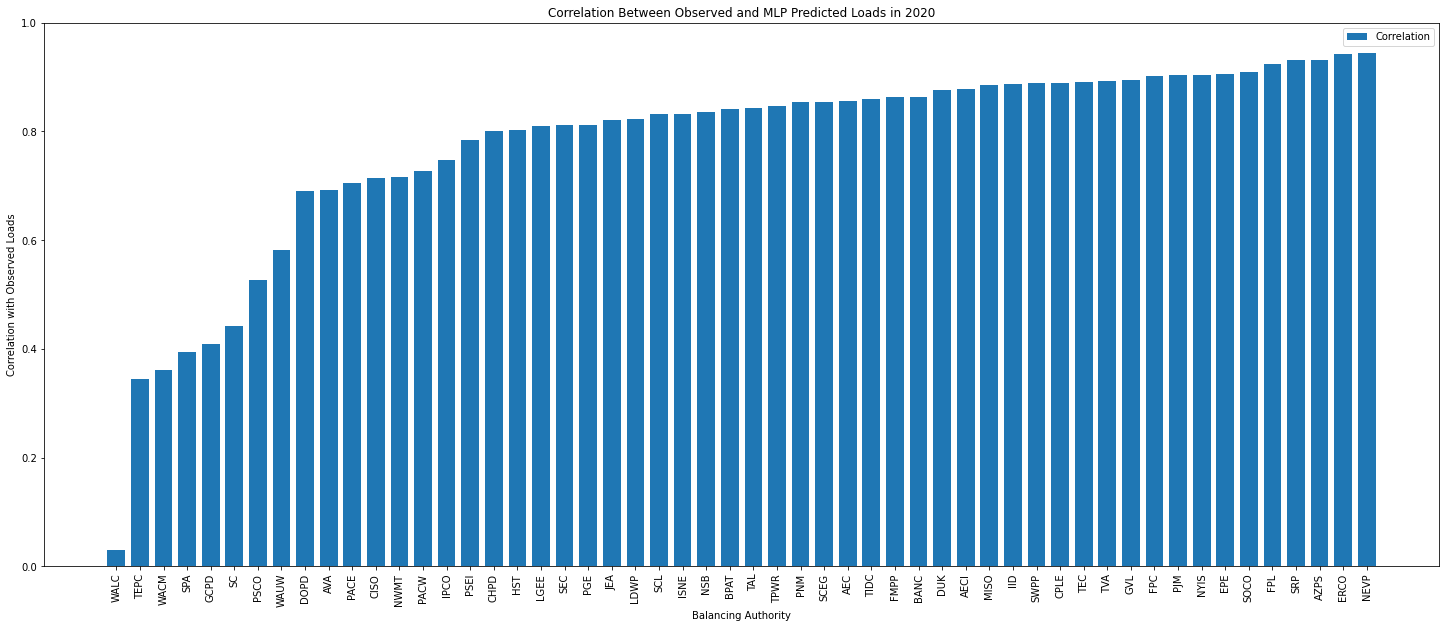

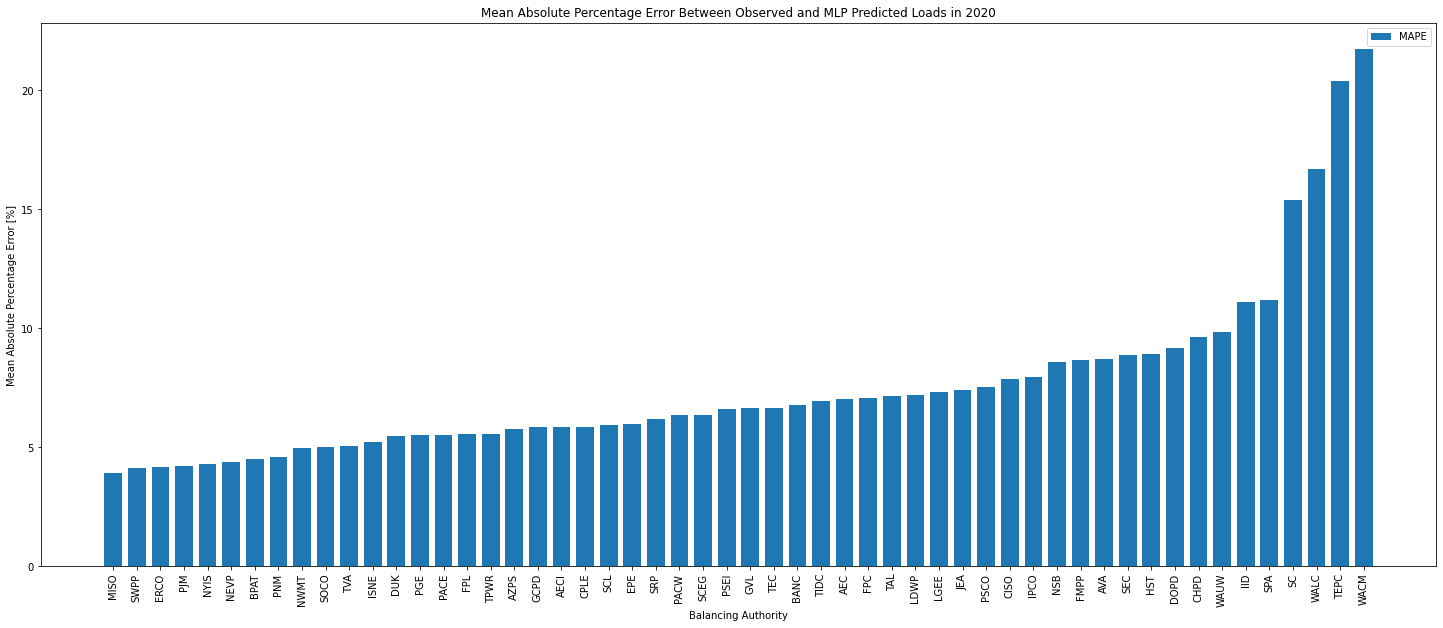

In [4]:
# See the performance of the MLP models across all the BAs in TELL:
tell.plot_mlp_summary_statistics(year_to_plot = '2020',
                                 data_input_dir = tell_data_dir, 
                                 image_output_dir = tell_image_dir,
                                 image_resolution = 150,
                                 save_images = False)


### 4.2. MLP model projection
Next we use the trained MLP models to project future loads in each BA using the sample climate forcing downloaded in Section 3.4. The outcomes of this projection step are then used in the forward execution of `tell` in Section 5.

In [ ]:
# Code block goes here...

## 5. Model forward execution

This section of the `tell` workflow takes the .csv files produced by the `tell` MLP models and distributes the projected load to the counties that each BA operates in. The county-level hourly loads are then summed to the state-level and scaled to match the state-level annual loads produced by GCAM-USA. Three sets of output files are generated: county-level hourly loads, state-level hourly loads, and hourly loads for each BA. There is one additional summary output file that includes state-level annual loads from TELL and GCAM-USA as well as the scaling factors. Note that since it takes a while to write out the county-level output data this output is optional. To output county-level load projections just set the "save_county_data" flag to True.

In [ ]:
# Run the TELL model forward in time for a given year:
tell.execute_forward(year_to_process = '2020',
                     scenario_to_process = 'rcp85hotter_ssp5',
                     data_input_dir = tell_data_dir,
                     save_county_data = False)


## 6. Model visualization

The final section of this quickstarter notebook plots some of the output of `tell` to give the user a flavor of what the model is doing. Because `tell` can take a few minutes to run we have pre-ran the model for the sample weather years described above. The first step in this section downloads that sample `tell` output data package from the [Zenodo data package](https://zenodo.org/record/6338472#.YieU0BPMJTY) and then visualizes the output in multiple ways. Note that the sample output data covers the years 2039, 2059, 2079, and 2099 so those are the only valid values for the "year_to_plot" variable in each function call.

In [ ]:
# Download the TELL sample output data package from Zenodo:
tell.install_sample_output_data(data_dir = tell_data_dir)


### 6.1. Plot a map of the state scaling factors

The first visualization plots the state level scaling factors that force the annual total loads projected by `tell` at the state-level to agree with those from GCAM-USA. Values closer to
1 indicate that the models are in closer agreement. In this case using the sample output (which relies on a generic GCAM-USA simulation) you shouldn't read too much into disagreements between the two models.

In [ ]:
# Plot the state-level scaling factors:
tell.plot_state_scaling_factors(year_to_plot = '2020', 
                                data_input_dir = tell_data_dir, 
                                image_output_dir = tell_image_dir,
                                image_resolution = 150,
                                save_images = True)


### 6.2. Plot the state annual total loads from GCAM-USA and `tell`

Next we plot the annual total loads from both GCAM-USA and `tell`. The data plotted here are in units of TWh and the `tell` values are the unscaled projections. The scaled projections `tell` are by definition equal to those from GCAM-USA.

In [ ]:
# Plot the annual total loads from both GCAM-USA and TELL:
tell.plot_state_annual_total_loads(year_to_plot = '2020',
                                   data_input_dir = tell_data_dir,
                                   image_output_dir = tell_image_dir,
                                   image_resolution = 150,
                                   save_images = True)


### 6.3. Plot the time-series of total hourly loads for a given state

Here we plot time-series of the raw (unscaled) and scaled total loads from `tell` at the state level. The user specifies which state they want to plot using the "state_to_plot" variable in the function call.

In [ ]:
# Plot the time-series of raw and scaled loads from TELL at the state level for a user-specified state:
tell.plot_state_load_time_series(state_to_plot = 'Texas', 
                                 year_to_plot = '2020',
                                 data_input_dir = tell_data_dir,
                                 image_output_dir = tell_image_dir,
                                 image_resolution = 150,
                                 save_images = True)


### 6.4. Plot the load duration curve for a given state

Our last plot at the state level is the load duration curve which shows the frequency at which a given load occurs in a state. The user specifies which state they want to plot using the "state_to_plot" variable in the function call.

In [ ]:
# Plot the load duration curve at the state level for a user-specified state:
tell.plot_state_load_duration_curve(state_to_plot = 'North Carolina', 
                                    year_to_plot = '2020',
                                    data_input_dir = tell_data_dir,
                                    image_output_dir = tell_image_dir,
                                    image_resolution = 150,
                                    save_images = False)


### 6.5. Plot the time-series of total hourly loads for a given BA

Our final visualization plots the time-series of the raw (unscaled) and scaled total loads from `tell` at the BA level. The user specifies which BA they want to plot using the "ba_to_plot" variable in the function call.

In [ ]:
# Plot the time-series of raw and scaled loads from TELL at the BA level for a user-specified BA (e.g., PJM, CISO, ERCO, etc.):
tell.plot_ba_load_time_series(ba_to_plot = 'PJM', 
                              year_to_plot = '2020',
                              data_input_dir = tell_data_dir,
                              image_output_dir = tell_image_dir,
                              image_resolution = 150,
                              save_images = True)
